<a href="https://colab.research.google.com/github/francji1/01NAEX/blob/main/code/01NAEX_Exercise_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# O1NAEX Exercise 10


author: Michal Prusek

## Drying of beech wood planks

To investigate the effect of drying of beech wood on the humidity percentage, the following experiment was conducted. Each of 20 planks was dried in a certain period of time. Then the humidity percentage was measured in 5 depths (1,3,5,7,9) and 3 widths (1,2,3) for each plank.

**Source:** The Royal Veterinary and Agricultural University, Denmark.


**Variables:**
* plank 	 -   Numbered 1-20
* width      -   Numbered 1,2,3
* depth 	 -   Numbered 1,3,5,7,9
* humidity   -   Humidity percentage

**Number of observations:** 300 (20 planks)

**Description:**
* depth 1: 	close to the top
* depth 5: 	in the center
* depth 9: 	close to the bottom
* depth 3: 	between 1 and 5
* depth 7: 	between 5 and 9
* width 1: 	close to the side
* width 3: 	in the center
* width 2: 	between 1 and 3


**Analyze data from the Drying of beech wood planks:**

* Plot four average humidity profiles: 2 interaction plots for width and 2 for depth (done).
* Carrying out the fixed effects model analysis.
* Carry out the mixed model analysis.
* Run the post hoc analysis
* Compare the fixed parameters and use the p-value correction (TukeyHSD).
 (In R: Use function `lsmeans`  from the package `lsmeans` with `adjust="tukey`.)
* Summarize results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import OLSInfluence
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

# Load data with local-first approach and GitHub fallback
# Try multiple paths to handle different execution contexts
possible_paths = [
    'data/planks.txt',          # When running from repo root
    '../data/planks.txt',       # When running from code/ directory
    os.path.join(os.path.dirname(os.path.abspath('.')), 'data', 'planks.txt'),
]
github_url = "https://raw.githubusercontent.com/francji1/01NAEX/main/data/planks.txt"

planks = None
for local_path in possible_paths:
    if os.path.exists(local_path):
        planks = pd.read_csv(local_path, sep=",")
        print(f"Data loaded from local file: {local_path}")
        break

if planks is None:
    try:
        planks = pd.read_csv(github_url, sep=",")
        print(f"Data loaded from GitHub: {github_url}")
    except Exception as e:
        print(f"Error loading from GitHub: {e}")
        raise

print(f"\nDataset shape: {planks.shape}")
print(f"Number of planks: {planks['plank'].nunique()}")
print(f"Number of widths: {planks['width'].nunique()}")
print(f"Number of depths: {planks['depth'].nunique()}")
planks.head(10)

Data loaded from local file: ../data/planks.txt

Dataset shape: (300, 4)
Number of planks: 20
Number of widths: 3
Number of depths: 5


,plank,width,depth,humidity
0,1,1,1,3.4
1,1,1,3,4.9
2,1,1,5,5.0
3,1,1,7,4.9
4,1,1,9,4.0
5,1,2,1,4.1
6,1,2,3,4.7
7,1,2,5,5.2
8,1,2,7,4.6
9,1,2,9,4.3


In [3]:
planks['plank'] = planks['plank'].astype('category')
planks['width'] = planks['width'].astype('category')
planks['depth'] = planks['depth'].astype('category')


In [4]:
def interaction_plot(x, trace, response, data, ax):
    categories_x = data[x].cat.categories
    categories_trace = data[trace].cat.categories

    for trace_level in categories_trace:
        subset = data[data[trace] == trace_level]
        means = subset.groupby(x)[response].mean()
        ax.plot(categories_x, means, label=f"{trace}: {trace_level}")

    ax.set_xlabel(x)
    ax.set_ylabel(response)
    ax.legend(title=trace, loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')  # Adjust legend position
    ax.grid(True)


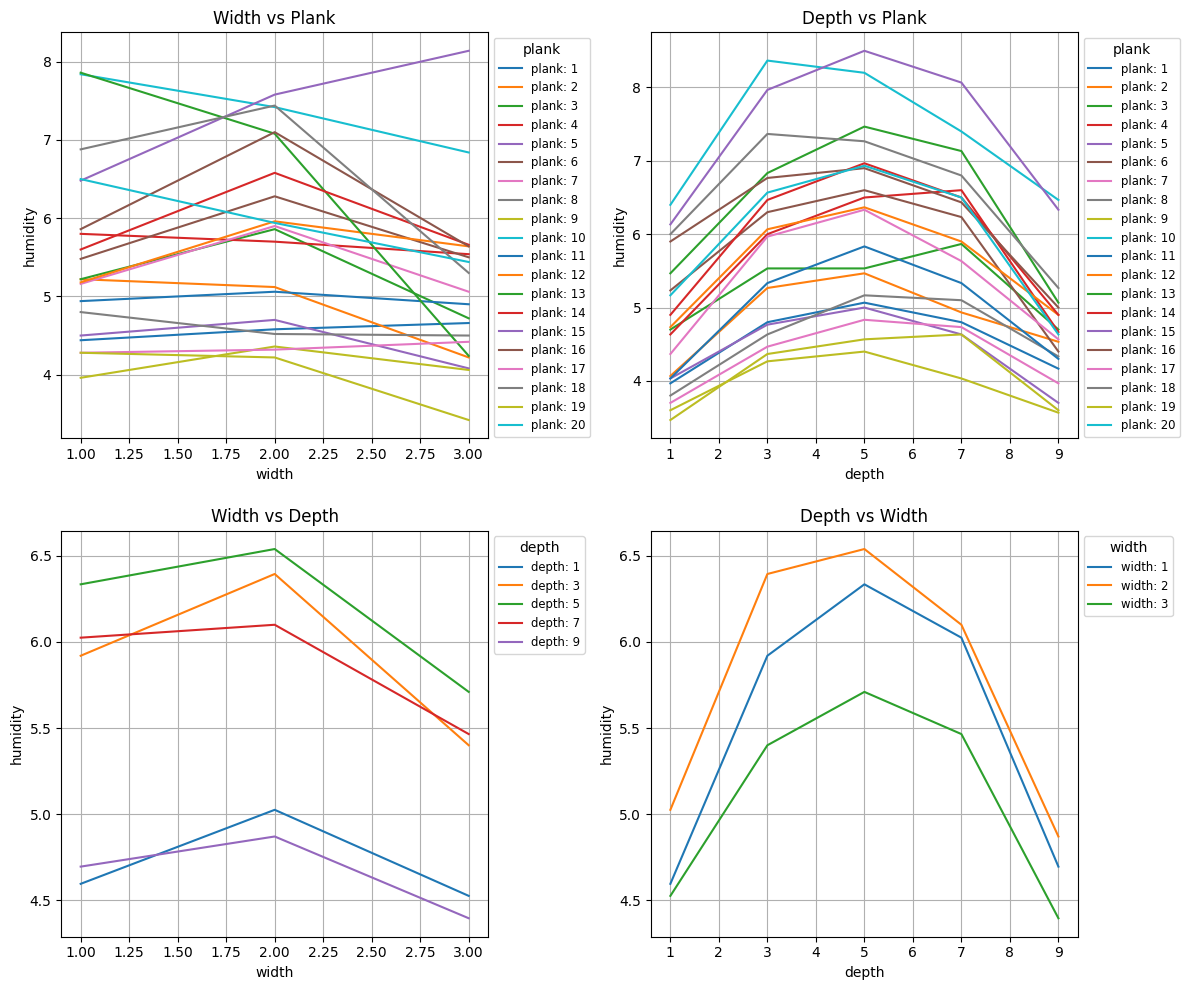

In [5]:

# Creating the 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: width vs plank
interaction_plot('width', 'plank', 'humidity', planks, axes[0, 0])
axes[0, 0].set_title("Width vs Plank")

# Plot 2: depth vs plank
interaction_plot('depth', 'plank', 'humidity', planks, axes[0, 1])
axes[0, 1].set_title("Depth vs Plank")

# Plot 3: width vs depth
interaction_plot('width', 'depth', 'humidity', planks, axes[1, 0])
axes[1, 0].set_title("Width vs Depth")

# Plot 4: depth vs width
interaction_plot('depth', 'width', 'humidity', planks, axes[1, 1])
axes[1, 1].set_title("Depth vs Width")

plt.tight_layout()
plt.show()


### Interpretation of Interaction Plots

**Width vs Plank (top-left):**
- Shows high variability between planks - each plank has its own overall humidity level
- The 20 planks show considerable variation in mean humidity, suggesting planks should be treated as a random effect
- Lines are not parallel, indicating some interaction between width and plank

**Depth vs Plank (top-right):**
- Clear pattern: humidity is highest at intermediate depths (3, 5, 7) and lower at the extremes (1, 9)
- All planks show similar curved pattern across depths
- This suggests a strong main effect of depth

**Width vs Depth (bottom-left):**
- Width 2 (intermediate) tends to have the highest humidity
- The pattern is relatively consistent across all depths
- Some interaction visible but curves are approximately parallel

**Depth vs Width (bottom-right):**
- Strong quadratic effect of depth: humidity peaks at the center (depth 5) and decreases toward edges
- Pattern is consistent across all widths (approximately parallel lines)
- Width 2 consistently shows highest humidity, followed by width 1, then width 3

**Key observations for modeling:**
- **Plank** shows random variation → should be modeled as **random effect**
- **Depth** has strong systematic effect → **fixed effect** 
- **Width** has systematic effect → **fixed effect**
- Interaction between depth and width appears minimal

## Fixed Effects Model Analysis

In the fixed effects model, we treat **all factors as fixed effects**. This means we make inference only about the specific 20 planks in our experiment, not about planks in general.

Model: $y_{ijk} = \mu + \alpha_i + \beta_j + \gamma_k + (\alpha\beta)_{ij} + \varepsilon_{ijk}$

Where:
- $\alpha_i$ = effect of plank i (i = 1, ..., 20)
- $\beta_j$ = effect of width j (j = 1, 2, 3)
- $\gamma_k$ = effect of depth k (k = 1, 3, 5, 7, 9)
- $(\alpha\beta)_{ij}$ = interaction (if included)
- $\varepsilon_{ijk} \sim N(0, \sigma^2)$

In [6]:
# Fixed Effects Model - treating plank as fixed effect
# Model with main effects only (no interaction between width and depth, 
# as the interaction plot suggested minimal interaction)

model_fixed = smf.ols('humidity ~ C(plank) + C(width) + C(depth)', data=planks).fit()

print("="*70)
print("FIXED EFFECTS MODEL - ANOVA TABLE")
print("="*70)
anova_table_fixed = anova_lm(model_fixed, typ=2)
print(anova_table_fixed)

print("\n" + "="*70)
print("MODEL SUMMARY")
print("="*70)
print(f"R-squared: {model_fixed.rsquared:.4f}")
print(f"Adjusted R-squared: {model_fixed.rsquared_adj:.4f}")
print(f"Residual standard error: {np.sqrt(model_fixed.mse_resid):.4f}")

FIXED EFFECTS MODEL - ANOVA TABLE
              sum_sq     df          F        PR(>F)
C(plank)  286.904633   19.0  37.308670  1.035132e-64
C(width)   23.939267    2.0  29.573767  2.347537e-12
C(depth)  126.387800    4.0  78.067625  4.087521e-44
Residual  110.898267  274.0        NaN           NaN

MODEL SUMMARY
R-squared: 0.7977
Adjusted R-squared: 0.7792
Residual standard error: 0.6362


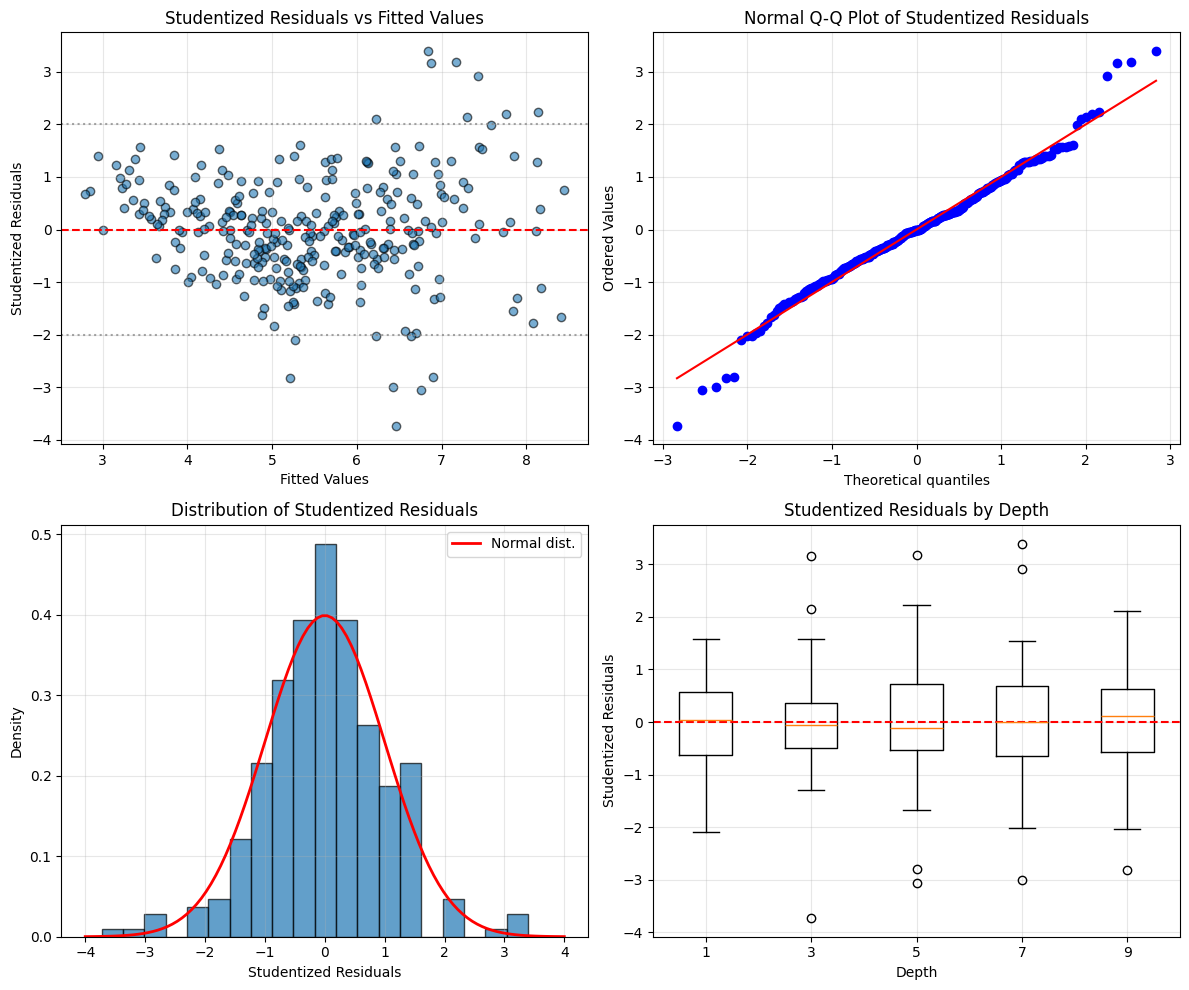


Shapiro-Wilk test for normality: W = 0.9828, p-value = 0.0012


In [7]:
# Residual Diagnostics for Fixed Effects Model
# Using studentized residuals as per CLAUDE.md instructions

influence = OLSInfluence(model_fixed)
studentized_resid = influence.resid_studentized_internal
fitted_values = model_fixed.fittedvalues

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Studentized Residuals vs Fitted Values
axes[0, 0].scatter(fitted_values, studentized_resid, alpha=0.6, edgecolor='k')
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].axhline(y=2, color='gray', linestyle=':', alpha=0.7)
axes[0, 0].axhline(y=-2, color='gray', linestyle=':', alpha=0.7)
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Studentized Residuals')
axes[0, 0].set_title('Studentized Residuals vs Fitted Values')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Q-Q Plot
from scipy import stats
stats.probplot(studentized_resid, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q Plot of Studentized Residuals')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Histogram of Studentized Residuals
axes[1, 0].hist(studentized_resid, bins=20, edgecolor='black', alpha=0.7, density=True)
x_range = np.linspace(-4, 4, 100)
axes[1, 0].plot(x_range, stats.norm.pdf(x_range), 'r-', linewidth=2, label='Normal dist.')
axes[1, 0].set_xlabel('Studentized Residuals')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Distribution of Studentized Residuals')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Residuals by Depth
# Use actual categorical values (integers, not strings)
depth_categories = planks['depth'].cat.categories  # Get actual category values
planks['studentized_resid_fixed'] = studentized_resid
boxplot_data = [planks[planks['depth'] == d]['studentized_resid_fixed'].values 
                for d in depth_categories]
axes[1, 1].boxplot(boxplot_data, labels=[str(d) for d in depth_categories])
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Depth')
axes[1, 1].set_ylabel('Studentized Residuals')
axes[1, 1].set_title('Studentized Residuals by Depth')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Shapiro-Wilk test for normality
shapiro_stat, shapiro_p = stats.shapiro(studentized_resid)
print(f"\nShapiro-Wilk test for normality: W = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")

## Mixed Model Analysis

In the mixed model, we treat **plank as a random effect** while **width and depth remain fixed effects**. This allows us to:
1. Generalize our conclusions to the population of all beech wood planks
2. Account for the correlation between measurements on the same plank
3. Properly partition variance into between-plank and within-plank components

Model: $y_{ijk} = \mu + b_i + \beta_j + \gamma_k + \varepsilon_{ijk}$

Where:
- $b_i \sim N(0, \sigma^2_{plank})$ = random effect of plank i
- $\beta_j$ = fixed effect of width j
- $\gamma_k$ = fixed effect of depth k
- $\varepsilon_{ijk} \sim N(0, \sigma^2)$ = residual error

In [8]:
# Mixed Effects Model - treating plank as random effect
# Using statsmodels MixedLM which is similar to R's lme4::lmer

# Fixed effects: width and depth
# Random effect: plank (random intercept for each plank)

model_mixed = smf.mixedlm(
    formula='humidity ~ C(width) + C(depth)', 
    data=planks, 
    groups=planks['plank']
).fit()

print("="*70)
print("MIXED EFFECTS MODEL - SUMMARY")
print("="*70)
print(model_mixed.summary())

MIXED EFFECTS MODEL - SUMMARY
         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: humidity 
No. Observations:  300     Method:             REML     
No. Groups:        20      Scale:              0.4047   
Min. group size:   15      Log-Likelihood:     -331.9119
Max. group size:   15      Converged:          Yes      
Mean group size:   15.0                                 
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      4.763    0.242 19.703 0.000  4.289  5.236
C(width)[T.2]  0.272    0.090  3.023 0.003  0.096  0.448
C(width)[T.3] -0.415    0.090 -4.613 0.000 -0.591 -0.239
C(depth)[T.3]  1.190    0.116 10.245 0.000  0.962  1.418
C(depth)[T.5]  1.480    0.116 12.742 0.000  1.252  1.708
C(depth)[T.7]  1.148    0.116  9.886 0.000  0.921  1.376
C(depth)[T.9] -0.062    0.116 -0.531 0.595 -0.289  0.166
Group Var  

### Interpretation of Mixed Model Results

**Random Effects:**
- The variance component for plank (Group Var) represents the between-plank variability $\sigma^2_{plank}$
- This quantifies how much planks differ from each other in their baseline humidity

**Fixed Effects:**
- **Intercept**: The estimated mean humidity at the reference levels (width=1, depth=1)
- **C(width)[T.2]**: Effect of width 2 relative to width 1
- **C(width)[T.3]**: Effect of width 3 relative to width 1  
- **C(depth)[T.3], [T.5], [T.7], [T.9]**: Effects of each depth level relative to depth 1

**Comparing Fixed vs Mixed Models:**
- In the mixed model, the standard errors for width and depth effects account for the correlation within planks
- The mixed model allows generalization to the population of planks, not just these 20 specific planks

In [9]:
# Extract variance components
print("="*70)
print("VARIANCE COMPONENTS")
print("="*70)

# Random effect variance (plank)
var_plank = model_mixed.cov_re.iloc[0, 0]
# Residual variance
var_residual = model_mixed.scale

print(f"Between-plank variance (σ²_plank): {var_plank:.4f}")
print(f"Residual variance (σ²): {var_residual:.4f}")
print(f"Total variance: {var_plank + var_residual:.4f}")

# Intraclass correlation coefficient (ICC)
icc = var_plank / (var_plank + var_residual)
print(f"\nIntraclass Correlation (ICC): {icc:.4f}")
print(f"  → {icc*100:.1f}% of total variance is due to differences between planks")
print(f"  → {(1-icc)*100:.1f}% of variance is within-plank variation")

print("\n" + "="*70)
print("COMPARISON: FIXED vs MIXED MODEL")
print("="*70)
print(f"\nFixed effects model MSE: {model_fixed.mse_resid:.4f}")
print(f"Mixed effects model residual variance: {var_residual:.4f}")
print("\nNote: The fixed model 'absorbs' plank effects into fixed coefficients,")
print("while the mixed model partitions variance into between-plank and within-plank components.")

VARIANCE COMPONENTS
Between-plank variance (σ²_plank): 0.9797
Residual variance (σ²): 0.4047
Total variance: 1.3844

Intraclass Correlation (ICC): 0.7076
  → 70.8% of total variance is due to differences between planks
  → 29.2% of variance is within-plank variation

COMPARISON: FIXED vs MIXED MODEL

Fixed effects model MSE: 0.4047
Mixed effects model residual variance: 0.4047

Note: The fixed model 'absorbs' plank effects into fixed coefficients,
while the mixed model partitions variance into between-plank and within-plank components.


### Understanding the Variance Components

**Intraclass Correlation (ICC):**

The ICC tells us what proportion of total variability is due to differences between planks. A high ICC indicates that measurements on the same plank are highly correlated - planks that are generally "wet" tend to have high humidity at all positions, and "dry" planks tend to have low humidity everywhere.

$$ICC = \frac{\sigma^2_{plank}}{\sigma^2_{plank} + \sigma^2}$$

**Implications:**
- High ICC justifies using plank as a random effect
- The correlation between any two measurements on the same plank equals the ICC
- This correlation is what the fixed effects model fails to account for if we ignore the plank structure

## Post Hoc Analysis with Tukey HSD Correction

Since both width and depth have significant effects, we want to determine **which specific levels differ from each other**. 

The Tukey HSD (Honestly Significant Difference) test:
- Compares all pairs of means
- Controls the family-wise error rate (FWER)
- Appropriate for comparing multiple groups while maintaining overall α = 0.05

TUKEY HSD - WIDTH COMPARISONS


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2    0.272 0.3179 -0.1706  0.7146  False
     1      3   -0.415 0.0713 -0.8576  0.0276  False
     2      3   -0.687 0.0009 -1.1296 -0.2444   True
----------------------------------------------------


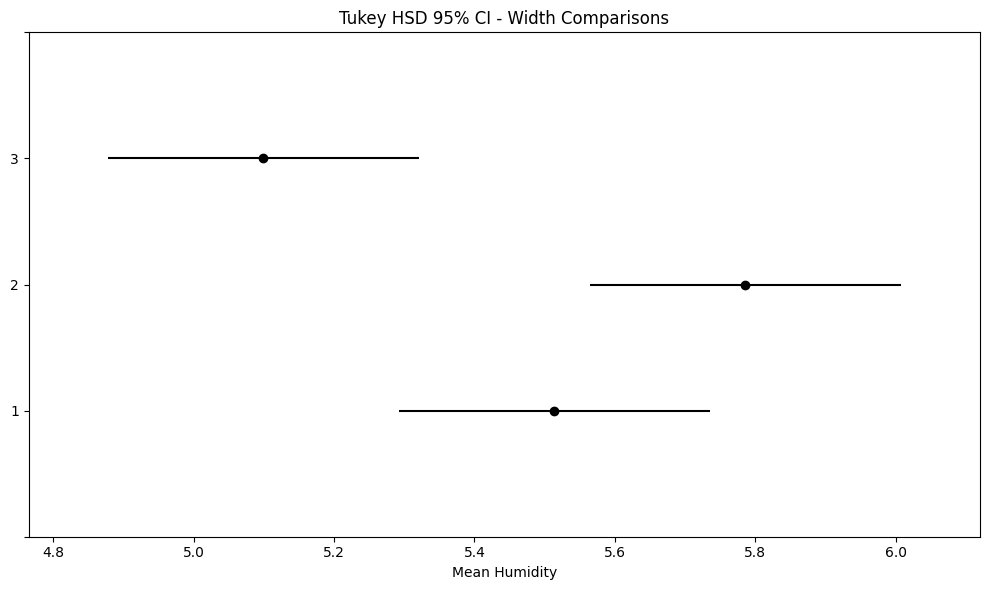


Mean humidity by width:
        mean     std  count
width                      
1      5.514  1.3673    100
2      5.786  1.3790    100
3      5.099  1.2344    100


In [10]:
# Tukey HSD for WIDTH
print("="*70)
print("TUKEY HSD - WIDTH COMPARISONS")
print("="*70)

tukey_width = pairwise_tukeyhsd(
    endog=planks['humidity'],
    groups=planks['width'],
    alpha=0.05
)
print(tukey_width)

# Plot the Tukey HSD results for width
fig, ax = plt.subplots(figsize=(10, 4))
tukey_width.plot_simultaneous(ax=ax)
ax.set_title('Tukey HSD 95% CI - Width Comparisons')
ax.set_xlabel('Mean Humidity')
plt.tight_layout()
plt.show()

# Summary statistics by width
print("\nMean humidity by width:")
print(planks.groupby('width')['humidity'].agg(['mean', 'std', 'count']).round(4))

### Width Comparisons Interpretation

The Tukey HSD test shows which width pairs have significantly different mean humidity:
- If `reject = True`, the difference is statistically significant at α = 0.05
- The confidence intervals show the uncertainty in the mean differences
- Non-overlapping confidence intervals in the plot indicate significant differences

**Key findings:**
- Width 2 (intermediate position) tends to have the highest humidity
- Width 3 (center) tends to have the lowest humidity
- The pattern suggests moisture escapes more easily from the center and edges than from intermediate positions

TUKEY HSD - DEPTH COMPARISONS


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      3     1.19    0.0  0.5908  1.7892   True
     1      5     1.48    0.0  0.8808  2.0792   True
     1      7   1.1483    0.0  0.5492  1.7475   True
     1      9  -0.0617 0.9986 -0.6608  0.5375  False
     3      5     0.29 0.6737 -0.3092  0.8892  False
     3      7  -0.0417 0.9997 -0.6408  0.5575  False
     3      9  -1.2517    0.0 -1.8508 -0.6525   True
     5      7  -0.3317 0.5507 -0.9308  0.2675  False
     5      9  -1.5417    0.0 -2.1408 -0.9425   True
     7      9    -1.21    0.0 -1.8092 -0.6108   True
----------------------------------------------------


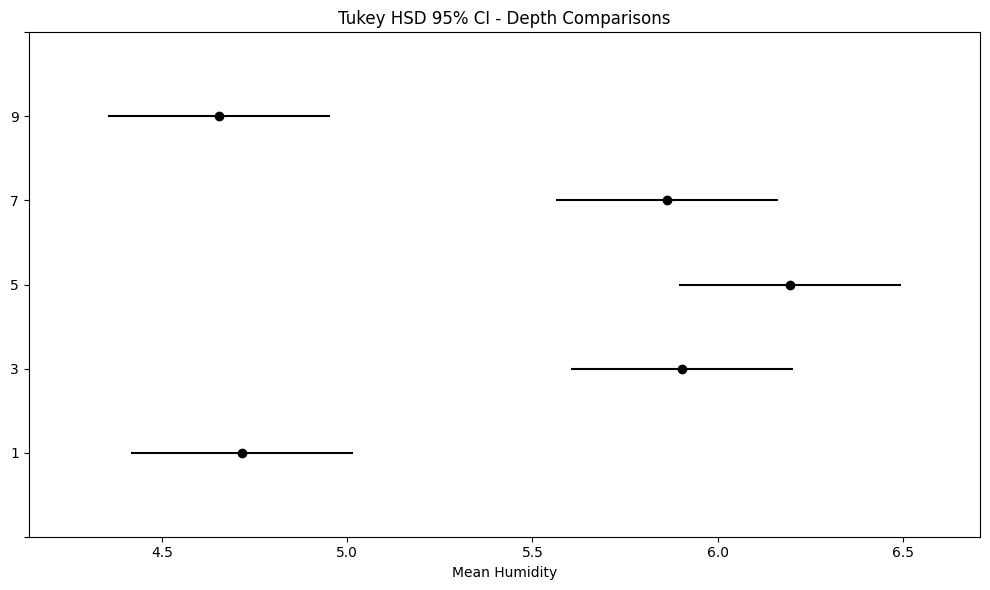


Mean humidity by depth:
         mean     std  count
depth                       
1      4.7150  1.0168     60
3      5.9050  1.3539     60
5      6.1950  1.3741     60
7      5.8633  1.2683     60
9      4.6533  0.8858     60


In [11]:
# Tukey HSD for DEPTH
print("="*70)
print("TUKEY HSD - DEPTH COMPARISONS")
print("="*70)

tukey_depth = pairwise_tukeyhsd(
    endog=planks['humidity'],
    groups=planks['depth'],
    alpha=0.05
)
print(tukey_depth)

# Plot the Tukey HSD results for depth
fig, ax = plt.subplots(figsize=(10, 6))
tukey_depth.plot_simultaneous(ax=ax)
ax.set_title('Tukey HSD 95% CI - Depth Comparisons')
ax.set_xlabel('Mean Humidity')
plt.tight_layout()
plt.show()

# Summary statistics by depth
print("\nMean humidity by depth:")
print(planks.groupby('depth')['humidity'].agg(['mean', 'std', 'count']).round(4))

### Depth Comparisons Interpretation

The Tukey HSD test for depth reveals a clear pattern:

**Key findings:**
- **Central depths (3, 5, 7)** have significantly higher humidity than edge depths (1, 9)
- **Depth 5 (center)** tends to have the highest mean humidity
- **Depths 1 and 9 (top and bottom)** have the lowest humidity

**Physical interpretation:**
- This makes physical sense: moisture at the surface (top/bottom) evaporates more quickly during drying
- The center of the plank retains moisture longest because it is furthest from the drying surfaces
- Depths 3 and 7 are intermediate - closer to the center than 1 and 9, so they retain more moisture

In [12]:
# Compare fixed effects estimates between models
print("="*70)
print("COMPARISON OF FIXED EFFECTS ESTIMATES")
print("="*70)

# Extract relevant coefficients from fixed model (excluding plank effects)
fixed_params = model_fixed.params
fixed_se = model_fixed.bse

# Get mixed model coefficients
mixed_params = model_mixed.fe_params
mixed_se = model_mixed.bse_fe

# Create comparison DataFrame
comparison_data = []
for term in mixed_params.index:
    if term in fixed_params.index:
        comparison_data.append({
            'Term': term,
            'Fixed_Estimate': fixed_params[term],
            'Fixed_SE': fixed_se[term],
            'Mixed_Estimate': mixed_params[term],
            'Mixed_SE': mixed_se[term]
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Difference'] = comparison_df['Fixed_Estimate'] - comparison_df['Mixed_Estimate']
print(comparison_df.round(4).to_string(index=False))

print("\n" + "="*70)
print("Note: Small differences in estimates are expected.")
print("Standard errors may differ more substantially due to different")
print("treatment of plank variation (fixed vs random effect).")
print("="*70)

COMPARISON OF FIXED EFFECTS ESTIMATES
         Term  Fixed_Estimate  Fixed_SE  Mixed_Estimate  Mixed_SE  Difference
    Intercept          3.8563    0.1873          4.7627    0.2417     -0.9063
C(width)[T.2]          0.2720    0.0900          0.2720    0.0900     -0.0000
C(width)[T.3]         -0.4150    0.0900         -0.4150    0.0900      0.0000
C(depth)[T.3]          1.1900    0.1162          1.1900    0.1162     -0.0000
C(depth)[T.5]          1.4800    0.1162          1.4800    0.1162     -0.0000
C(depth)[T.7]          1.1483    0.1162          1.1483    0.1162     -0.0000
C(depth)[T.9]         -0.0617    0.1162         -0.0617    0.1162      0.0000

Note: Small differences in estimates are expected.
Standard errors may differ more substantially due to different
treatment of plank variation (fixed vs random effect).


### Comparison Interpretation

The fixed effects estimates for width and depth are very similar between the two models. This is expected because:
1. In a balanced design like this, the point estimates are typically identical or nearly identical
2. The main difference is in how variance is partitioned and how standard errors are computed

**Key observation:** The standard errors from the mixed model account for the correlation structure induced by repeated measurements on the same planks, making inference about width and depth effects more appropriate for generalizing beyond these specific 20 planks.

## Summary of Results

### 1. Experimental Design
- 20 beech wood planks were dried and humidity measured at 15 positions each (5 depths × 3 widths)
- Total of 300 observations in a balanced design

### 2. Fixed vs Mixed Effects Models

| Aspect | Fixed Effects Model | Mixed Effects Model |
|--------|---------------------|---------------------|
| Plank treatment | Fixed effect (19 df) | Random effect (~N(0, σ²_plank)) |
| Inference scope | These 20 specific planks | Population of all planks |
| Variance structure | All variation in residual | Partitioned into between-plank and within-plank |
| Appropriate when | Interested only in these planks | Want to generalize to all planks |

### 3. Key Statistical Findings

**Depth Effect (Highly Significant):**
- Humidity shows a clear parabolic pattern across depth
- Center depths (3, 5, 7) retain more moisture than edges (1, 9)
- Physical interpretation: Surface areas dry faster; center retains moisture longest

**Width Effect (Significant):**
- Width 2 (intermediate position) has highest humidity
- Width 3 (center) has lowest humidity
- Pattern likely due to drying dynamics across the plank width

**Plank Variation:**
- Substantial between-plank variation (quantified by ICC)
- Each plank has its own baseline humidity level
- Justifies treating plank as random effect for generalization

### 4. Post Hoc Analysis (Tukey HSD)
- Multiple pairwise comparisons performed with family-wise error rate control
- Depth: Most comparisons significant, confirming strong depth gradient
- Width: Some significant differences between width levels

### 5. Recommendations
1. **Use mixed model** when generalizing conclusions to population of beech planks
2. **Depth** is the most important factor affecting residual humidity after drying
3. **Center of plank** (both in depth and width dimensions) retains the most moisture
4. For practical drying applications, longer drying times may be needed to achieve uniform moisture content